In [1]:
import sklearn
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
import glob
import re
from pathlib import Path
from collections import defaultdict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score,StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix,f1_score,ConfusionMatrixDisplay)

In [2]:
df = pd.read_csv('all_subjects_segmented.csv')
df = df.drop(columns=["subject", "window_start"])
df = df[df['class'] != -1]

imputer = SimpleImputer(strategy='mean')
df_filled = imputer.fit_transform(df)

df_final = pd.DataFrame(df_filled)

df_final = df_final.fillna(0)
df_final.columns = df.columns

#df_final.iloc[0]

x = df_final.drop(columns=['class'])
y = df_final['class']

In [3]:
#outliers 
iso = IsolationForest(contamination=0.01, random_state=42)
mask = iso.fit_predict(x) == 1  # 1 = inlier
x = x[mask]
y = y[mask]

#nomalization 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

In [4]:
print(df['class'].value_counts())

class
2    12954
5     5884
3     3329
0     2418
1     1821
4      356
Name: count, dtype: int64


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

C:\Users\amalf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\amalf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [11]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)


param_dist = {
    'n_estimators':      [100, 200],
    'max_depth':         [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf':  [1, 2],
    'max_features':      ['sqrt']
    
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [12]:
search.fit(X_train, y_train)
best_rf = search.best_estimator_
print("▶ Best hyper-parameters:", search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
▶ Best hyper-parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}



Test accuracy: 0.832

Confusion Matrix:
 [[ 303   20  107    3    0   33]
 [  35   85  196    6    0   36]
 [  80   39 2365   30    4   60]
 [  26    0   45  586    3    3]
 [   0    1    1    5   55    2]
 [  65    9   77    2    0 1017]]

Weighted F1-score: 0.823

Classification Report:
               precision    recall  f1-score   support

         0.0      0.595     0.650     0.622       466
         1.0      0.552     0.237     0.332       358
         2.0      0.847     0.917     0.881      2578
         3.0      0.927     0.884     0.905       663
         4.0      0.887     0.859     0.873        64
         5.0      0.884     0.869     0.876      1170

    accuracy                          0.832      5299
   macro avg      0.782     0.736     0.748      5299
weighted avg      0.824     0.832     0.823      5299



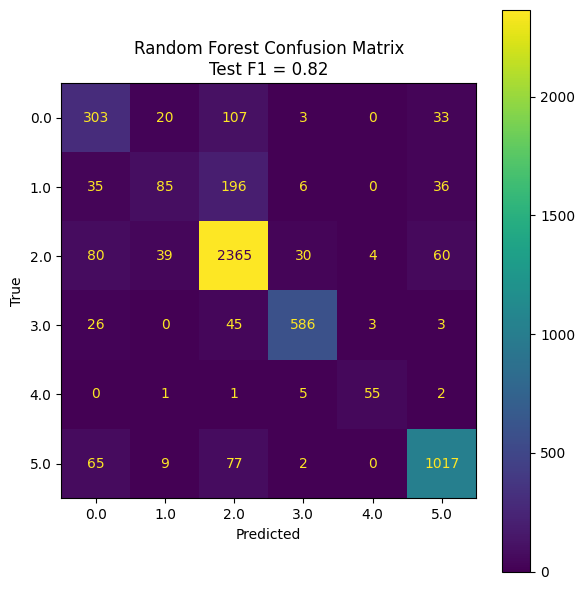

In [13]:
y_pred = best_rf.predict(X_test)

print(f"\nTest accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"\nWeighted F1-score: {f1_score(y_test, y_pred, average='weighted'):.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))

# 2. Compute confusion matrix & weighted F1
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# 3. Store in a results dict
results = {
    'Random Forest': {
        'cm':      cm,
        'f1_test': f1
    }
}

# 4. Plot using your loop
for name, res in results.items():
    disp = ConfusionMatrixDisplay(
        confusion_matrix=res['cm'],
        display_labels=np.unique(y_test)   # or best_rf.classes_
    )
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, values_format='d')
    ax.set_title(f"{name} Confusion Matrix\nTest F1 = {res['f1_test']:.2f}")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.tight_layout()
    plt.show()



C:\Users\amalf\AppData\Local\Temp\ipykernel_31604\2085606571.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')


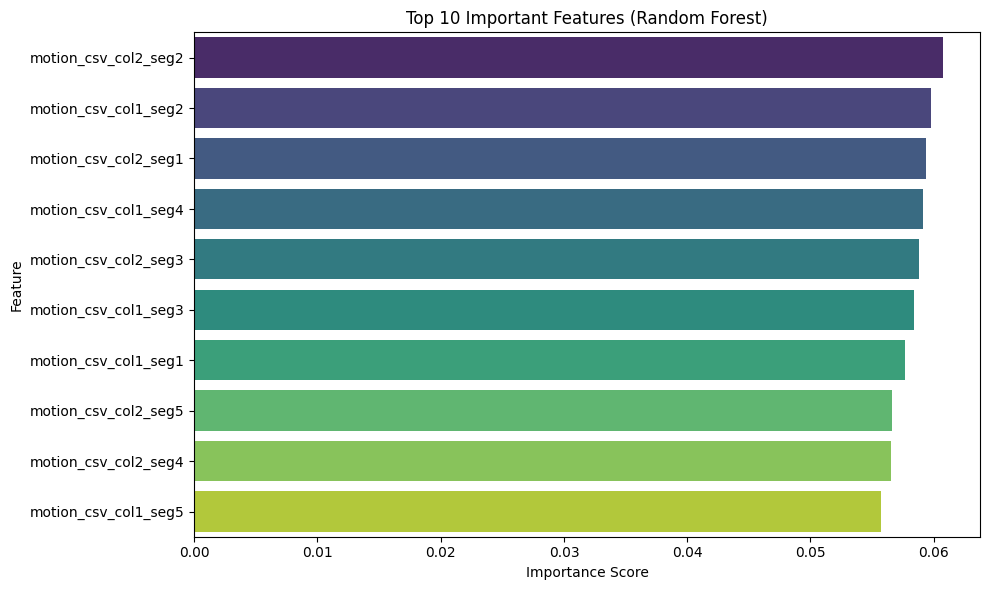

In [14]:
import seaborn as sns

feature_names = x.columns

importances = best_rf.feature_importances_

feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)  # Top 10

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')
plt.title('Top 10 Important Features (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:

importances = best_rf.feature_importances_
feature_names = x.columns
top_indices = np.argsort(importances)[-20:][::-1]
top_features = feature_names[top_indices]

print("Top 10 Features:\n", top_features)

X_top10 = x[top_features]
scaler = StandardScaler()
X_scaled_top10 = scaler.fit_transform(X_top10)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_top10, y, test_size=0.2, stratify=y, random_state=42
)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

rf_top = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,  
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)

rf_top.fit(X_train_res, y_train_res)
y_pred_top = rf_top.predict(X_test)

print("▶ Accuracy (Top 10 Features):", accuracy_score(y_test, y_pred_top))
print("\nClassification Report:\n", classification_report(y_test, y_pred_top, digits=3))

Top 10 Features:
 Index(['motion_csv_col2_seg2', 'motion_csv_col1_seg2', 'motion_csv_col2_seg1',
       'motion_csv_col1_seg4', 'motion_csv_col2_seg3', 'motion_csv_col1_seg3',
       'motion_csv_col1_seg1', 'motion_csv_col2_seg5', 'motion_csv_col2_seg4',
       'motion_csv_col1_seg5', 'motion_csv_col3_seg2', 'motion_csv_col3_seg4',
       'motion_csv_col3_seg1', 'motion_csv_col3_seg3', 'motion_csv_col3_seg5',
       'heart_rate_csv_col1_seg5', 'heart_rate_csv_col1_seg4',
       'heart_rate_csv_col1_seg3', 'heart_rate_csv_col1_seg2',
       'heart_rate_csv_col1_seg1'],
      dtype='object')
▶ Accuracy (Top 10 Features): 0.8322324966974901

Classification Report:
               precision    recall  f1-score   support

         0.0      0.567     0.747     0.644       466
         1.0      0.452     0.458     0.455       358
         2.0      0.913     0.867     0.889      2578
         3.0      0.903     0.902     0.903       663
         4.0      0.891     0.891     0.891        64
    